In [1]:
using ITensors
using ProgressMeter
using RandomMeas
using Revise

In [29]:
N = 12
steps = 10
ξ = siteinds("Qubit", N)
states = ["Dn" for n in 1:N]
cutoff = 1e-4
ψ = MPS[]
push!(ψ,MPS(ξ,states));
circuit_layer = Vector{Vector{ITensor}}()
@showprogress dt=1 for d in 1:steps
        push!(circuit_layer,RandomCircuit(ξ,2))
        push!(ψ,apply(circuit_layer[d],ψ[d];cutoff=cutoff))
end
println("State prepared")
println("with bond dimension (pure state) ", maxlinkdim(ψ[steps+1]))

State prepared
with bond dimension (pure state) 61


In [32]:
ntraj = 1
NM = 1000
Fidelity = zeros(Float64,steps)
XEB = zeros(Float64,steps)
selfXEB = zeros(Float64,steps)
p = 0.02 *rand(N)
u = get_rotations(ξ,6)
for d in 1:steps
    P0 = get_Born_MPS(ψ[d+1])
    selfXEB[d] = 2^N*real(inner(P0,P0))-1
end
@showprogress for traj in 1:ntraj
    ψt = MPS(ξ,states);
    for d in 1:steps
        ψt = apply(circuit_layer[d],ψt;cutoff=cutoff)
        DepoCircuit = RandomPauliLayer(ξ,p)
        ψt = apply(DepoCircuit,ψt;cutoff=cutoff)
        Fidelity[d] += real(inner(ψt,ψ[d+1]))/ntraj

        
        #data = get_RandomMeas_MPS(normalize(ψt),u,1)
        data = sample(normalize(orthogonalize(ψt,1)),NM)
        for m in 1:NM
            V = ITensor(1.)
            for j=1:N
                ψj = ψ[d+1][j]*state(ξ[j],data[j])
                V *= ψj*dag(ψj')
            end
            XEB[d] += (2^N*real(V[])-1)/NM
        end
    end
end

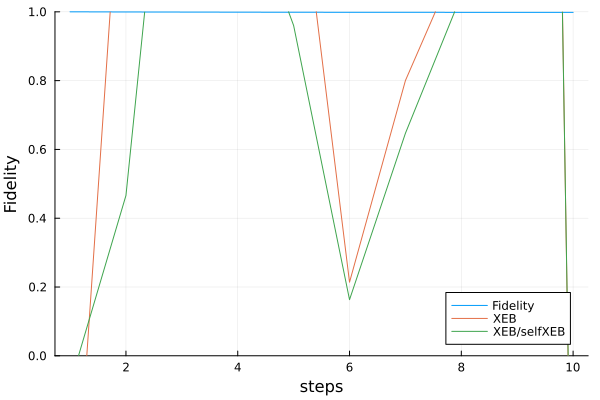

In [33]:
using Plots
plot(1:steps,Fidelity,label="Fidelity")
plot!(1:steps,XEB,label="XEB")
plot!(1:steps,XEB./selfXEB,label="XEB/selfXEB")
xlabel!("steps")
ylabel!("Fidelity")
ylims!((0,1))